In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Ch11. Training Deep Neural Networks
- 얕은 네트워크 만으로는 고해상도 이미지에서 수백 종류의 물체를 감지하는 등의 복잡한 물체를 다룰 수가 없다. (이미지 분류, 텍스트 분석등의 작업이라고 해서 반드시 convolution layer이나 revolution layer을 사용해야 하는 것이 아니다. deep neural network으로도 충분히 가능하다.)
- 훈련 중에 발생할 수있는 문제로는 
  - 그래디언트 소실, 그래디언트 폭주와 같이 신경층의 아래쪽으로 갈수록 그래디언트가 점점 작아지거나 커지는 현상
  - 충분하지 않은 훈련 데이터나 까다로운 레이블 만드는 작업
  - 극단적으로 느린 훈련 속도
  - 너무 많은 parameter에 의한 과대 적합  
등이 있다.


**이제부터 이러한 문제들에 대한 해결책을 찾아보자**  
**대부분의 공부한 내용은 노트에 적었기 때문에 여기는 간단하게 핵심만 적고자 한다.**

### 11.1 그래디언트 소실과 폭주 문제
- 불안정한 그래디언트 문제를 해결하기 위해서는 첫째, 입력의 분산이 출력의 분산과 같아야 하며 둘쨰, 역방향에서의 층 통과 전후의 그래디언트 분산이 동일해야 한다.
1. 글로럿과 He 초기화, 르쿤 초기화
2. 수렴하지 않는 활성화 함수
  - LeakyReLU, RReLU, PReLU, ELU
3. Batch Normalization
4. Gradient Clipping

### 11.2 사전 훈련된 층 재사용하기

### 11.3 고속 옵티마이저
1. Momentum 최적화  
  ```optimizer = tf.keras.optimizers.SGD(lr = 0.001, momentum = 0.9)```
2. Nestrov 가속 경사  
  ```optimizer = tf.keras.optimizers.SGD(lr = 0.001, momentum = 0.9, nestrov = True)```
3. AdaGrad
4. RMSProp  
```optimizer = tf.keras.optimizers.RMSProp(lr = 0.001, rho = 0.9)```
5. Adam, Nadam  
```optimizer = tf.keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)```
6. 학습률 스케줄링


### 11.4 규제를 사용해 과대 적합 피하기
1. L1 and L2 규제  
```
tf.keras.layers.Dense(  
    100, activation = 'elu',   
    kernel_initializer = 'he_normal', 
    kernel_regularizer = tf.keras.regularizers.l2(0.01))
```
2. Dropout
3. MCDropout
  - 기본 Dropout와의 유일한 차이는 dropout rate를 학습을 가능하게 해서 부정확도를 더 정밀하게 판단할 수 있도록 했다는 것이다.
4. max-norm regulation

### CIFAR 10 이미지 데이터셋을 이용해서 간단한 CNN + DNN layer을 만들어서 학습을 해 보았다. 
- 그 결과 epoch를 크게 하지는 않았기 때문에 정확도가 높게 나오지는 않았지만, 일단 이 단원의 연습문제에서 이 데이터셋을 이용해서 배운내용을 바탕으로 심층 신경망을 더 잘, 높은 정확도로 학습시키는 것이 있기 때문에 그렇게 심층 학습 전에 한번 그게 없다면 어느 정도의 학습률일지 확인해보는 차원에서 시도를 해 보았다.
- 그러나 relu대신 selu를 써서인지 생각보다는 결과를 시각화 했을 때는 맞춘 것이 많았다.  
**중요한 것은 여기서 softmax 함수를 출력층에 사용을 하는데, 10개의 class로 분류를 하기 때문이다. 그런데 그냥 y_test와 y_train을 넣으면 안되고 반드시 이를 one-hot encoding (tf.keras.utils.to_categorical 이용) 해서 input과 output shape을 맞춰 주어야 한다.

In [97]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [98]:
len(x_train), len(y_train), len(x_test), len(y_test)

(50000, 50000, 10000, 10000)

In [99]:
from tensorflow.keras.utils import to_categorical
y_test, y_train = to_categorical(y_test), to_categorical(y_train)

In [100]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [101]:
x_train = tf.image.convert_image_dtype(x_train, dtype = tf.float64)/255.0
x_test = tf.image.convert_image_dtype(x_test, dtype = tf.float64)/255.0
x_val = tf.image.convert_image_dtype(x_val, dtype = tf.float64)/255.0

In [102]:
x_train[0].shape

TensorShape([32, 32, 3])

1. train_test_split으로 train, valid데이터 나누어주기
2. image데이터와 label 데이터 mapping해서 하나의 dataset으로 만들어주기
3. train_dataset shuffle, batch, prefetch해주기
4. ImageDataGenerator을 이용해서 이미지 데이터 증식해주기 (하려고 했으나 하기에는 이미지의 화질이 너무 좋지 않았다.)
5. convolution layer이 아니기 때문에 dense layer에 입력 데이터를 넣기에 앞서서 Flatten layer을 이용해 주어야 함 
6. 마지막 은닉층 전, 즉 출력층 바로 전에 BatchNormalization layer을 넣었다.

In [84]:
def add_image_label(image, label):
  for i in range(len(image)):
    return (image[i], label[i])

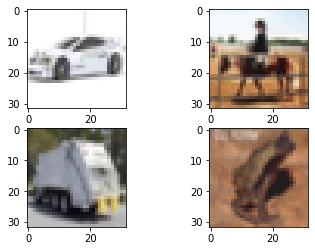

In [85]:
for i in range(0,20,5):
  plt.subplot(2,2,i//5+1)
  plt.imshow(x_train[i]*255.0)

In [86]:
len(x_train)

40000

In [103]:
BUFFER_SIZE = len(x_train)
BATCH_SIZE = 32
max_epochs = 10
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).prefetch(1)

In [104]:
train_dataset

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float64, tf.float32)>

In [108]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.activations import softmax, selu
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(128, input_shape = [32,32,3], kernel_size = 2, padding = 'same', strides = 2))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(300, activation = 'selu'))
model.add(Dense(100, activation = 'selu'))
model.add(Dense(10, activation = 'softmax'))

In [109]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 128)       1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_196 (Dense)            (None, 300)               2457900   
_________________________________________________________________
dense_197 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_198 (Dense)            (None, 10)                1010      
Total params: 2,490,674
Trainable params: 2,490,674
Non-trainable params: 0
___________________________________________

- 한가지 추가를 하자면 batch normalization은 일반적으로 출력 스케일 벡터, 출력 이동 벡터 두개만 parameter에 의해서 학습하는 것과 달리 최종 입력 평균 벡터와 최종 입력 표준편차 벡터까지 학습을 하기 때문에 필터의 개수의 4배만큼의 parameter을 요구한다.
- 하지만 Batch Normalization을 이용할 때의 주의사항이 존재하는데, 바로 parameter의 조절이다.
**합성곱 신경망에 적용한다고 할 때에는 axis의 값을 이왕이면 axis = [1,2]로 설정해서 모든 픽셀 값에 대해서 batch normalization 연산을 진행하도록 하는 것이 좋다. 그렇지 않으면 이미지 픽셀의 열마다 하나씩 평균과 표준편차를 구해서 이를 해당열에 모든 픽셀에 동일하게 적용할 것이기 때문이다.
  - 배치 정규화는 입력을 정규화하고 다음 스케일을 정규화하고 이동 시킨다.
  - 만약에 입력 데이터를 정규화하지 않고 첫번째 층에 이 layer을 사용한다면 굳이 훈련세트의 표준화가 필요 없을 것이다.

In [110]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])
hist_3 = model.fit(train_dataset, validation_data = val_dataset, steps_per_epoch= len(x_train)//BATCH_SIZE, epochs = 25)

Epoch 1/25
1250/1250 [==============================] - 72s 58ms/step - loss: 1.8606 - accuracy: 0.3381 - val_loss: 1.6946 - val_accuracy: 0.4058
Epoch 2/25
1250/1250 [==============================] - 72s 58ms/step - loss: 1.6034 - accuracy: 0.4371 - val_loss: 1.6407 - val_accuracy: 0.4260
Epoch 3/25
1250/1250 [==============================] - 72s 57ms/step - loss: 1.4694 - accuracy: 0.4847 - val_loss: 1.4522 - val_accuracy: 0.4929
Epoch 4/25
1250/1250 [==============================] - 72s 58ms/step - loss: 1.3676 - accuracy: 0.5243 - val_loss: 1.3550 - val_accuracy: 0.5300
Epoch 5/25
1250/1250 [==============================] - 72s 58ms/step - loss: 1.2988 - accuracy: 0.5481 - val_loss: 1.3076 - val_accuracy: 0.5422
Epoch 6/25
1250/1250 [==============================] - 71s 57ms/step - loss: 1.2280 - accuracy: 0.5715 - val_loss: 1.2794 - val_accuracy: 0.5603
Epoch 7/25
1250/1250 [==============================] - 70s 56ms/step - loss: 1.1887 - accuracy: 0.5866 - val_loss: 1.2691 -

In [111]:
model.evaluate(test_dataset)

313/313 [==============================] - 3s 9ms/step - loss: 1.1835 - accuracy: 0.6100


[1.1835253238677979, 0.6100000143051147]

Accuracy = 61%

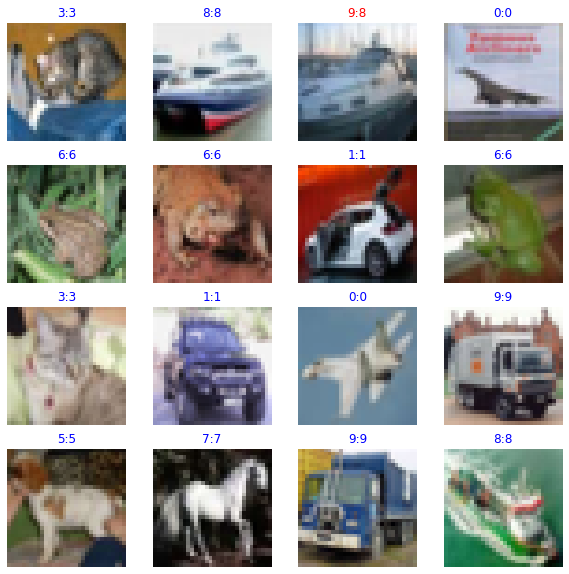

In [113]:
import numpy as np
plt.figure(figsize = (10,10))
i = 1
for image, label in test_dataset.take(1):
  pred = model.predict(image)
  for j in range(16):
    pred_y = np.argmax(pred[j])
    y = np.argmax(label[j])
    plt.subplot(4,4,i)
    i += 1
    plt.imshow(image[j]*255.0)
    if pred_y == y:
      plt.title('{}:{}'.format(pred_y, y),color = 'b')
    else:
      plt.title('{}:{}'.format(pred_y, y),color = 'r')
    plt.axis('off')
plt.show()

    

### 이제 CH.11의 연습 문제의 8번이 요구한 순서에 맞춰서 학습 성능을 CIFAR10 데이터로 높여보자.  
1. 100개의 뉴런을 가진 은닉층 20개로 심층 신경망을 만드시오
2. Nadam optimizer과 조기 종료를 사용하여 cifar10을 학습시키시오

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Conv2D, MaxPool2D
from tensorflow.keras.activations import elu

In [49]:
model_1 = Sequential()
model_1.add(Flatten(input_shape = [32,32,3]))
for _ in range(20):
  model_1.add(Dense(100, activation = 'elu', kernel_initializer='he_normal'))
model_1.add(Dense(10, activation = 'softmax'))

In [58]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [59]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [19]:
len(x_train), len(x_test), len(x_val)

(40000, 10000, 10000)

In [65]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [66]:
x_train = tf.image.convert_image_dtype(x_train, tf.float32)/255.0
x_test = tf.image.convert_image_dtype(x_test, tf.float32)/255.0
x_val = tf.image.convert_image_dtype(x_val, tf.float32)/255.0

BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().batch(BATCH_SIZE).prefetch(1)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).prefetch(1)

In [67]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 20)
optimizer = tf.keras.optimizers.Nadam(lr=5e-5)
model_1.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

**클래스를 그냥 정수 label 그대로 둘거면 loss로 'sparse_categorical_crossentropy'를 이용해야 하고 이 label을 to_categorical()을 이용해서 one-hot encoding을 한다면 loss로 'categorical_crossentropy'를 해야 한다.

In [68]:
hist_1 = model_1.fit(train_dataset, validation_data = val_dataset, epochs=50, steps_per_epoch=len(x_train)//BATCH_SIZE, callbacks=[early_stop])

Epoch 1/50
1250/1250 [==============================] - 15s 12ms/step - loss: 1.9078 - accuracy: 0.3101 - val_loss: 1.7951 - val_accuracy: 0.3491
Epoch 2/50
1250/1250 [==============================] - 15s 12ms/step - loss: 1.7248 - accuracy: 0.3829 - val_loss: 1.7270 - val_accuracy: 0.3803
Epoch 3/50
1250/1250 [==============================] - 15s 12ms/step - loss: 1.6478 - accuracy: 0.4090 - val_loss: 1.6763 - val_accuracy: 0.4028
Epoch 4/50
1250/1250 [==============================] - 15s 12ms/step - loss: 1.5940 - accuracy: 0.4277 - val_loss: 1.6187 - val_accuracy: 0.4207
Epoch 5/50
1250/1250 [==============================] - 15s 12ms/step - loss: 1.5571 - accuracy: 0.4417 - val_loss: 1.5856 - val_accuracy: 0.4292
Epoch 6/50
1250/1250 [==============================] - 14s 12ms/step - loss: 1.5303 - accuracy: 0.4530 - val_loss: 1.5652 - val_accuracy: 0.4341
Epoch 7/50
1250/1250 [==============================] - 15s 12ms/step - loss: 1.5083 - accuracy: 0.4600 - val_loss: 1.5510 -

In [69]:
model_1.evaluate(test_dataset)

313/313 [==============================] - 1s 2ms/step - loss: 1.6199 - accuracy: 0.4669


[1.6199029684066772, 0.4668999910354614]

Accuracy = 46.69%

3. 배치 정규화를 추가하고 학습 곡선을 비교해 보시오.
4. 배치 정규화를 selu로 바꾸고 입력 특성 표준화, 르쿤 정규분포 표준화, 완전 연결 층만으로 이루어진 심층 신경망 등 네트워크가 자기 정규화를 하기 위해 필요한 변경 사항을 적용해 보시오.

In [73]:
model_2 = Sequential()
model_2.add(Flatten(input_shape = [32,32,3]))
for _ in range(20):
  model_2.add(Dense(100, activation = 'selu', kernel_initializer='lecun_normal'))
model_2.add(Dense(10, activation = 'softmax'))

In [75]:
optimizer = tf.keras.optimizers.Nadam(lr=5e-5)

model_2.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
hist_2 = model_2.fit(train_dataset, validation_data = val_dataset, epochs = 50, steps_per_epoch=len(x_train)//BATCH_SIZE, callbacks = [early_stop])

Epoch 1/50
1250/1250 [==============================] - 14s 11ms/step - loss: 1.8992 - accuracy: 0.3041 - val_loss: 1.7752 - val_accuracy: 0.3481
Epoch 2/50
1250/1250 [==============================] - 14s 11ms/step - loss: 1.7192 - accuracy: 0.3763 - val_loss: 1.7134 - val_accuracy: 0.3829
Epoch 3/50
1250/1250 [==============================] - 14s 11ms/step - loss: 1.6372 - accuracy: 0.4104 - val_loss: 1.6647 - val_accuracy: 0.4069
Epoch 4/50
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5804 - accuracy: 0.4335 - val_loss: 1.6351 - val_accuracy: 0.4174
Epoch 5/50
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5417 - accuracy: 0.4452 - val_loss: 1.5856 - val_accuracy: 0.4406
Epoch 6/50
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5107 - accuracy: 0.4579 - val_loss: 1.5912 - val_accuracy: 0.4376
Epoch 7/50
1250/1250 [==============================] - 14s 11ms/step - loss: 1.4843 - accuracy: 0.4676 - val_loss: 1.5676 -

In [76]:
model_2.evaluate(test_dataset)

313/313 [==============================] - 1s 2ms/step - loss: 1.6267 - accuracy: 0.4743


[1.6266804933547974, 0.47429999709129333]

Accuracy = 47.43%

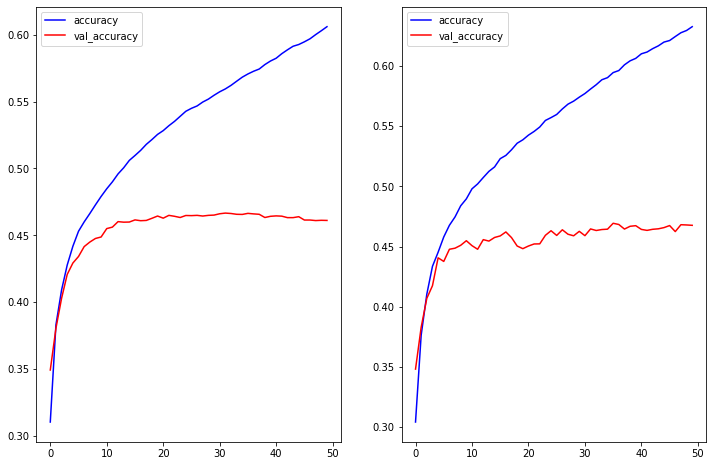

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
plt.plot(hist_1.history['accuracy'],'b-', label = 'accuracy')
plt.plot(hist_1.history['val_accuracy'], 'r-', label = 'val_accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_2.history['accuracy'],'b-', label = 'accuracy')
plt.plot(hist_2.history['val_accuracy'], 'r-', label = 'val_accuracy')
plt.legend()
plt.show()

### 정리
1. DNN과 다른 신경망이 함께 쓰일 때에 DNN에 적용할 가이드 라인
- 커널 초기화 : He 초기화
- 활성화 함수 : ELU
- 정규화 : 깊은 신경망이면 Batch Normalization
- 규제 : Early Stopping
- optimizer : momentum 최적화
- 학습률 : 1 cycle

2. DNN만 쓰이는 경우 DNN에 적용할 가이드 라인
- 커널 초기화 : 르쿤 초기화 (lecun_normal)
- 활성화 함수 : SELU
- 정규화 : 없음 (르쿤 초기화를 쓰면 자기 정규화가 가능한 모델이 된다)
- 규제 : 필요시 Alpha Dropout
- optimizer : momentum 최적화
- 학습률 : 1 cycle



**무엇보다 중요한 것은 학습률의 설정인 것 같다. 그리고 아무래도 무엇을 학습하느냐에 따라서 어떤 신경망을 이용하는지가 매울 중요할 것 같은데, 위의 결과에서도 알 수 있었지만 CNN을 한 층이라도 이용했을 때는 얕은 Dense layer에도 불구하고 학습률이 훨씬 높게 나왔었다.**
**최적의 학습률을 찾는 과정은 계속 시도를 해보거나 아니면 1cycle등과 같은 scheduler을 이용하면 학습률을 감소하는 방향으로 학습률 자체를 갱신할 수 있다. keras에는 1 cycle scheduler이 없기 때문에 직접 함수를 구현해야 한다.**

- 그게 아니라면, 즉 sklearn의 모델들을 사용한 경우에는 GridSearchCV와 같은 기능을 이용해서 최적의 hyperparameter을 찾을 수 있다.